In [1]:
from trainer import *
from data_sampling import *
from visualize import *
from utility_functions import *
import heat_equation_steady_state_network as network
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Deep Galerkin Method with Heat Equation in 1D

In [2]:
lx_1d = 2.0
bounds_1d = [[0.0, lx_1d]]
alpha = 1

# Data Sizes
N_INT = 1500
N_BC =800

## Data Preparation

In [3]:
# 1. Domain Data (x in [0, lx_1d])
x_int = generate_domain_points(N_INT, bounds_1d)
f_x = source_term_fn_1D(x_int, alpha).to(device)
domain_data = (x_int, f_x)

# 2 Boundary Points
c_bc = generate_bc_points(N_BC, bounds_1d)
u_bc = boundary_condition_fn_1D(c_bc).to(device)
bc_data = (c_bc, u_bc)

## Visualizing the Generated Domain and Boundary points

In [4]:
#visualize_points_1d(x_int,c_bc, bounds_1d)

## Network Initialization

In [5]:
num_layers = 5
nodes_per_layer = 64
learning_rate = 0.001
epochs = 2300

model = network.DGMNet(nodes_per_layer, num_layers, 1).to(device)

trainer = DGMTrainerSS(
    model=model,
    learning_rate=learning_rate,
    alpha=alpha
)

## Training

In [6]:
trainer.train(
    epochs=epochs,
    domain_data=domain_data,
    bc_data=bc_data,
    lambda_pde=5000.0,
    lambda_bc=5000.0,
    resample=True,
    sampling_config={
        'n_int': N_INT,
        'n_bc': N_BC,
        'bounds': bounds_1d
    }
)

Starting training on mps. Resampling: True
Epoch 100/2300 | Total Loss: 1414.4829 | L_pde: 0.1885 | L_bc: 0.0944
Epoch 200/2300 | Total Loss: 46.1648 | L_pde: 0.0091 | L_bc: 0.0002
Epoch 300/2300 | Total Loss: 9.9637 | L_pde: 0.0020 | L_bc: 0.0000
Epoch 400/2300 | Total Loss: 4.1297 | L_pde: 0.0008 | L_bc: 0.0000
Epoch 500/2300 | Total Loss: 3.2279 | L_pde: 0.0006 | L_bc: 0.0000
Epoch 600/2300 | Total Loss: 2.0317 | L_pde: 0.0004 | L_bc: 0.0000
Epoch 700/2300 | Total Loss: 1.6430 | L_pde: 0.0003 | L_bc: 0.0000
Epoch 800/2300 | Total Loss: 1.2923 | L_pde: 0.0003 | L_bc: 0.0000
Epoch 900/2300 | Total Loss: 17.6963 | L_pde: 0.0029 | L_bc: 0.0006
Epoch 1000/2300 | Total Loss: 1.0373 | L_pde: 0.0002 | L_bc: 0.0000
Epoch 1100/2300 | Total Loss: 60.9313 | L_pde: 0.0104 | L_bc: 0.0018
Epoch 1200/2300 | Total Loss: 0.8752 | L_pde: 0.0002 | L_bc: 0.0000
Epoch 1300/2300 | Total Loss: 6.3503 | L_pde: 0.0011 | L_bc: 0.0002
Epoch 1400/2300 | Total Loss: 24.8872 | L_pde: 0.0037 | L_bc: 0.0013
Epoch 1

## Loss History

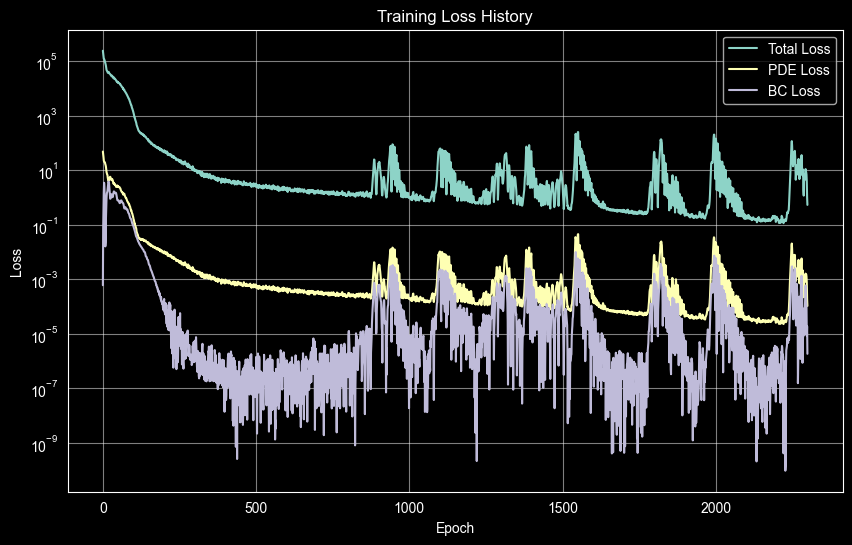

In [7]:
visualize_loss(trainer)

## Quantitative Error Analysis

In [8]:
x_test = torch.linspace(0, lx_1d, 1000).reshape(-1, 1).to(device)
error = calculate_relative_l2_error(model, x_test, analytical_function_1d)
print(f"Relative L2 Error: {error:.4e}")

Relative L2 Error: 2.5111e-03


## Visualizing the Solution [u(x)]

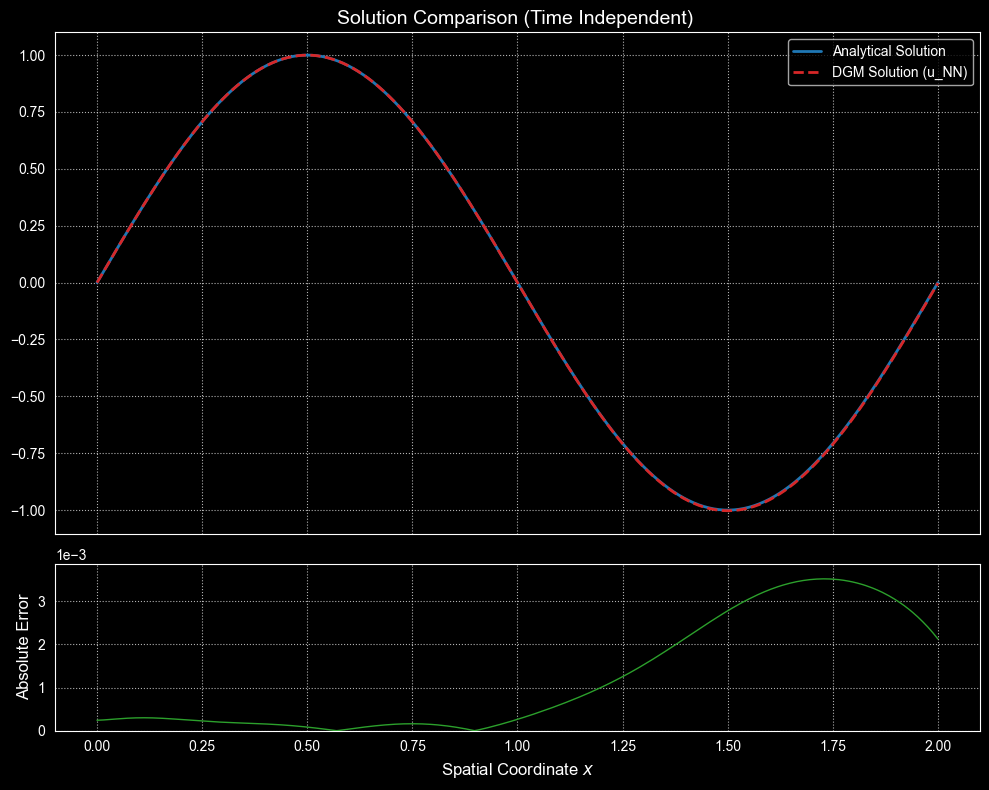

In [9]:
visualize_solution_1d(model, lx_1d,n_test_points=500)

# Deep Galerkin Method with Heat Equation in 2D

In [10]:
lx_2d = 2.0
ly_2d = 2.0
T_max = 2.0
bounds_2d = [[0.0, lx_2d],[0.0, ly_2d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 1

# Data Sizes
N_INT = 2000
N_BC =800

## Data Preparation

In [11]:
# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
spatial_coords = generate_domain_points(N_INT, bounds_2d)
x_int = spatial_coords[:, 0:1]
y_int = spatial_coords[:, 1:2]
f_xy = source_term_fn_2D(x_int, y_int,ALPHA).to(device)
interior_data = (x_int, y_int,  f_xy)


# 2. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
spatial_coords_bc = generate_bc_points(N_BC, bounds_2d)
x_bc = spatial_coords_bc[:, 0:1]
y_bc = spatial_coords_bc[:, 1:2]
u_bc = boundary_condition_fn_2D(x_bc, y_bc).to(device)
bc_data = (x_bc,y_bc, u_bc)

## Visualizing the Generated Domain and Boundary Points

In [12]:
#visualize_points_2d(spatial_coords, spatial_coords_bc, bounds_2d)

## Network Initialization

In [13]:
num_layers = 6
nodes_per_layer = 64
learning_rate = 0.001
epochs = 5000

model = network.DGMNet(nodes_per_layer, num_layers, 2).to(device)

trainer = DGMTrainerSS_2D(
    model=model,
    learning_rate=learning_rate,
    alpha=ALPHA
)

## Training

In [14]:
trainer.train(
    epochs=epochs,
    domain_data=interior_data,
    bc_data=bc_data,
    lambda_pde=5.0,
    lambda_bc=5.0,
    resample=True,
    sampling_config={
        'n_int': N_INT,
        'n_bc': N_BC,
        'bounds': bounds_2d
    }
)

Starting training on mps. Resampling: True
Epoch 100/5000 | Total Loss: 3.0827 | L_pde: 0.5465 | L_bc: 0.0701
Epoch 200/5000 | Total Loss: 0.7972 | L_pde: 0.1286 | L_bc: 0.0309
Epoch 300/5000 | Total Loss: 0.2371 | L_pde: 0.0369 | L_bc: 0.0106
Epoch 400/5000 | Total Loss: 0.1465 | L_pde: 0.0250 | L_bc: 0.0043
Epoch 500/5000 | Total Loss: 0.0741 | L_pde: 0.0128 | L_bc: 0.0020
Epoch 600/5000 | Total Loss: 0.0881 | L_pde: 0.0155 | L_bc: 0.0021
Epoch 700/5000 | Total Loss: 0.0305 | L_pde: 0.0049 | L_bc: 0.0012
Epoch 800/5000 | Total Loss: 0.0253 | L_pde: 0.0041 | L_bc: 0.0010
Epoch 900/5000 | Total Loss: 0.1031 | L_pde: 0.0193 | L_bc: 0.0013
Epoch 1000/5000 | Total Loss: 0.0184 | L_pde: 0.0028 | L_bc: 0.0009
Epoch 1100/5000 | Total Loss: 0.0759 | L_pde: 0.0141 | L_bc: 0.0011
Epoch 1200/5000 | Total Loss: 0.2691 | L_pde: 0.0526 | L_bc: 0.0012
Epoch 1300/5000 | Total Loss: 0.0282 | L_pde: 0.0048 | L_bc: 0.0009
Epoch 1400/5000 | Total Loss: 0.0239 | L_pde: 0.0038 | L_bc: 0.0009
Epoch 1500/500

## Loss History

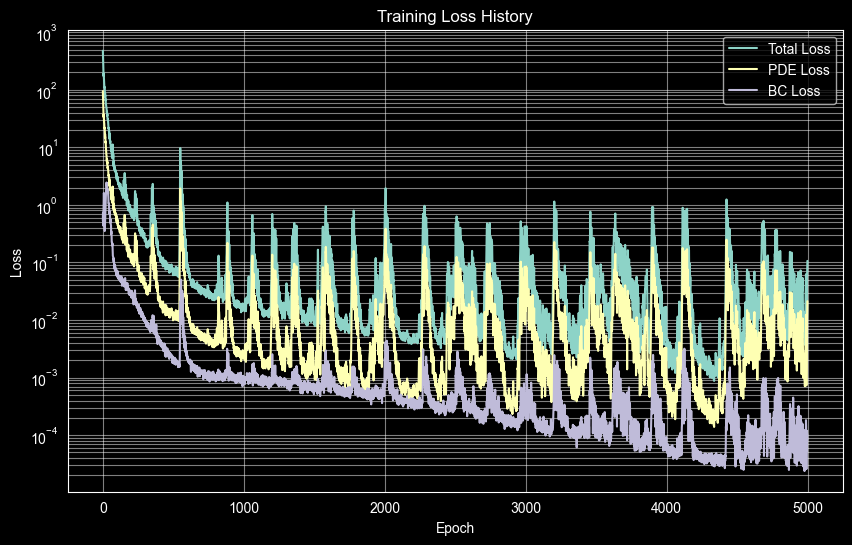

In [15]:
visualize_loss(trainer)

## Quantitative Error Analysis

In [16]:
x_test = torch.linspace(0, lx_2d, 100).to(device)
y_test = torch.linspace(0, ly_2d, 100).to(device)
X, Y = torch.meshgrid(x_test, y_test, indexing='ij')
x_flat = X.reshape(-1, 1)
y_flat = Y.reshape(-1, 1)
error = calculate_relative_l2_error_2d(model, x_flat, y_flat, analytical_function_2d)
print(f"Relative L2 Error: {error:.4e}")

Relative L2 Error: 2.0127e-01


## Visualizing the Solution [ u(x,y) ]

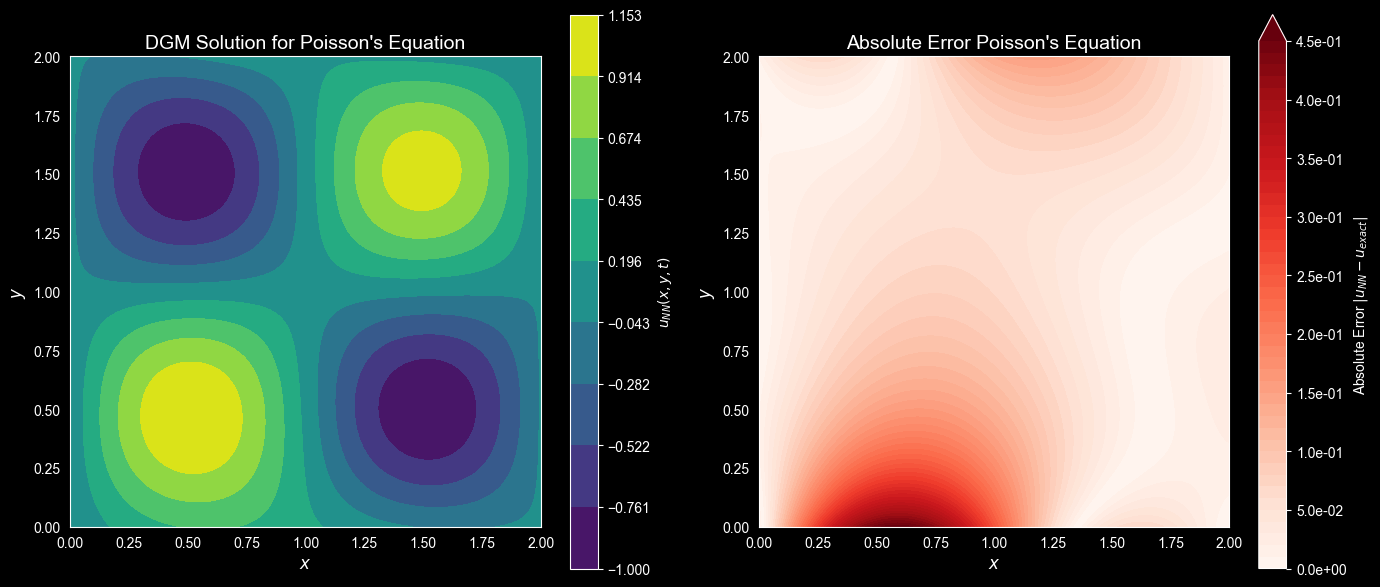

In [17]:
visualize_2d(
    model=model,
    bounds=bounds_2d,
    n_grid=500
)

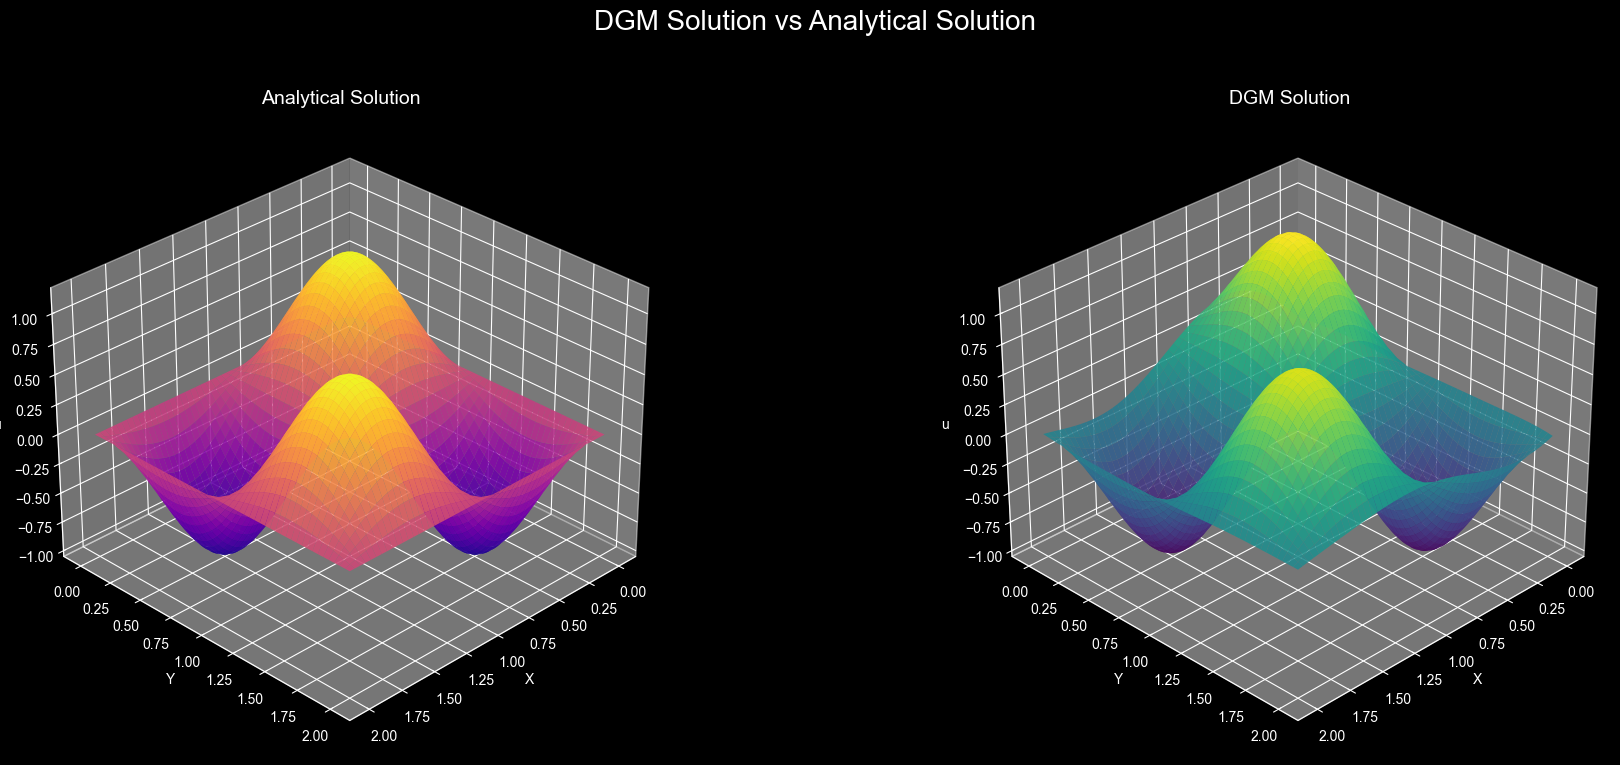

In [18]:
visualize_solution_2d(
    model=model,
    bounds=bounds_2d,
    n_grid=500
)